# Student Performance Prediction

**Dataset:** xAPI-Edu-Data (UCI)

This notebook performs EDA, preprocessing, trains a Random Forest classifier to predict student performance class (High/Medium/Low), evaluates the model, and saves `model.pkl` and `scaler.pkl` for a Streamlit UI.




In [14]:
# If running in a fresh environment, uncomment and run the following to install required packages.
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost joblib streamlit

print("If you need packages, uncomment the pip install line and run this cell.")

If you need packages, uncomment the pip install line and run this cell.


In [15]:
# Step 1: Download dataset automatically (if internet is available).
# The notebook attempts to fetch the dataset from the UCI repository.
# If this fails, download manually and place 'xAPI-Edu-Data.csv' in the notebook folder.

import os
from urllib import request
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/xAPI-Edu-Data.csv"
filename = "xAPI-Edu-Data.csv"

if os.path.exists(filename):
    print(f"Dataset already exists: {filename}")
else:
    try:
        print("Downloading dataset from UCI...")
        request.urlretrieve(url, filename)
        print("Download completed.")
    except Exception as e:
        print("Automatic download failed.\nError:", e)
        print("Please download 'xAPI-Edu-Data.csv' from:\nhttps://archive.ics.uci.edu/ml/datasets/xAPI-Edu-Data\nand place it in this folder.")

Dataset already exists: xAPI-Edu-Data.csv


In [16]:
# Step 2: Load libraries and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

sns.set(style='whitegrid')
%matplotlib inline

df = pd.read_csv("xAPI-Edu-Data.csv")
print("Shape:", df.shape)
df.head()

Shape: (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [17]:
# Step 3: Basic info and missing values
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object
 14  ParentschoolSatisfaction  

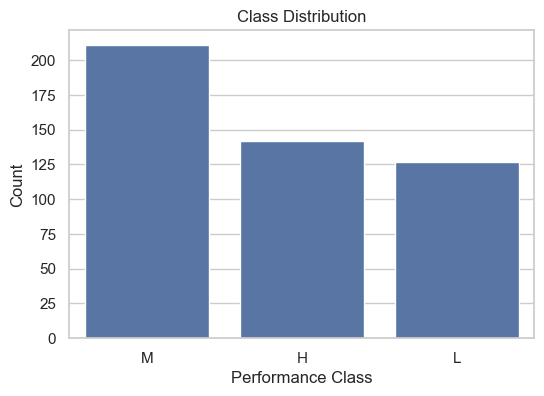

Class
M    211
H    142
L    127
Name: count, dtype: int64


In [18]:
# Step 4: Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, order=df['Class'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Performance Class')
plt.ylabel('Count')
plt.show()

print(df['Class'].value_counts())

In [19]:
# Step 5: Encode categorical features using LabelEncoder
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = le.fit_transform(df_encoded[col])

print('Encoded dataframe shape:', df_encoded.shape)
df_encoded.head()

Encoded dataframe shape: (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,1,4,4,2,1,0,7,0,0,15,16,2,20,1,1,1,2
1,1,4,4,2,1,0,7,0,0,20,20,3,25,1,1,1,2
2,1,4,4,2,1,0,7,0,0,10,7,0,30,0,0,0,1
3,1,4,4,2,1,0,7,0,0,30,25,5,35,0,0,0,1
4,1,4,4,2,1,0,7,0,0,40,50,12,50,0,0,0,2


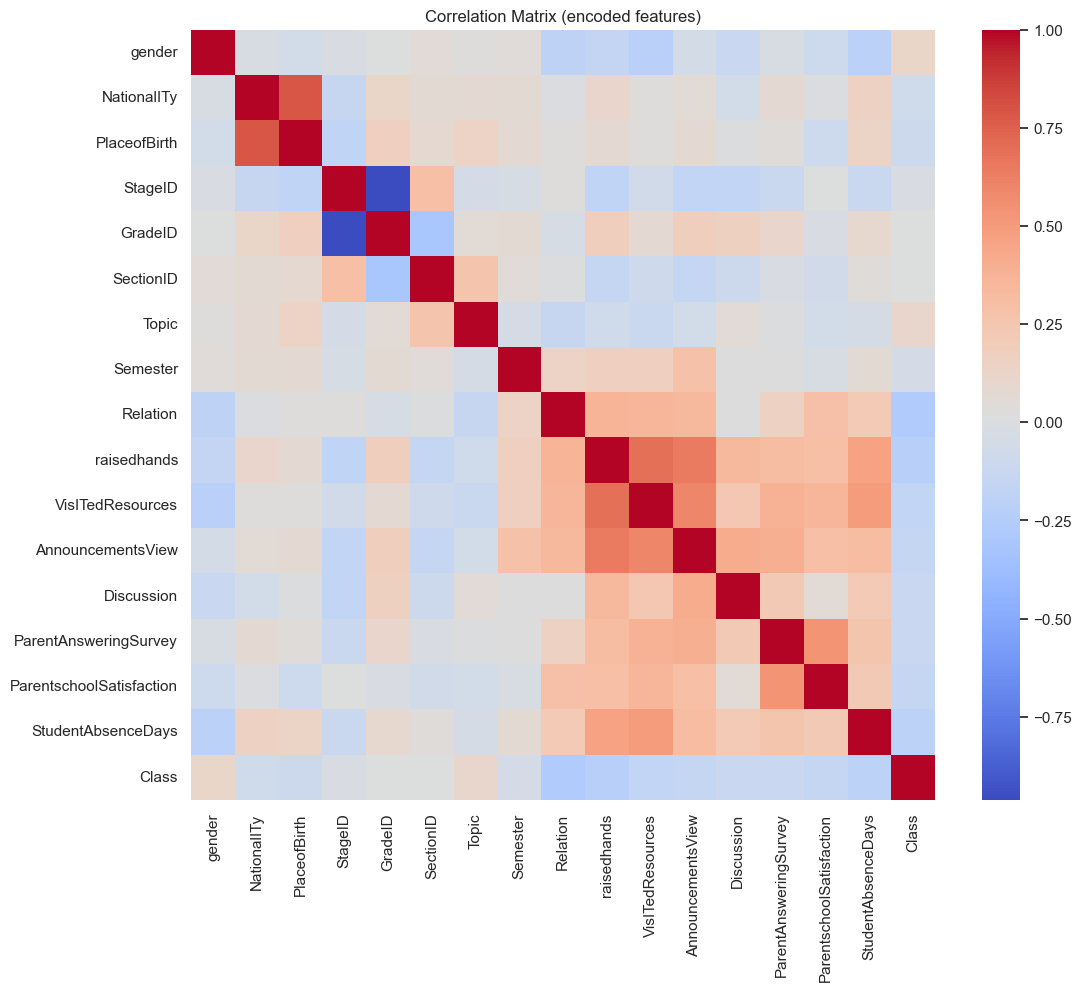

In [20]:
# Step 6: Correlation heatmap
plt.figure(figsize=(12,10))
corr = df_encoded.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (encoded features)')
plt.show()

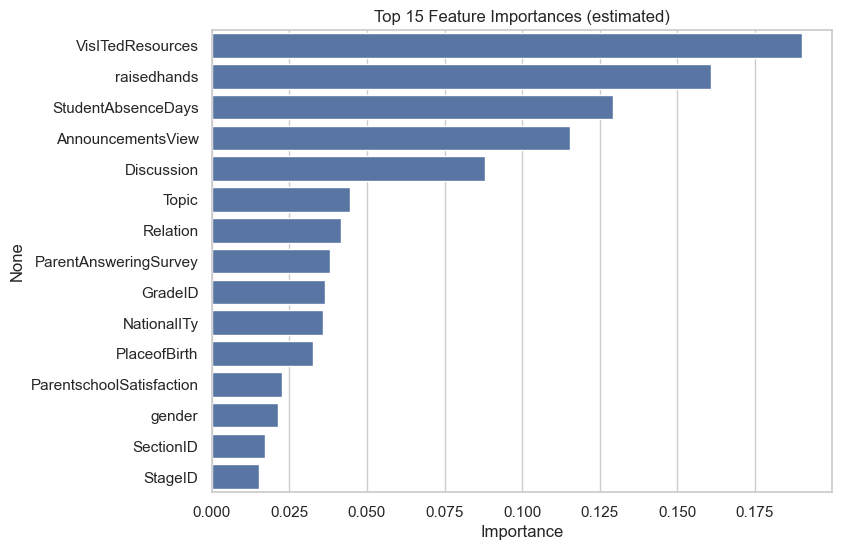

In [21]:
# Step 7: Quick feature importance estimate (untrained -> use RandomForest on full data to get importances)
X = df_encoded.drop('Class', axis=1)
y = df_encoded['Class']

# Fit a quick RF to get feature importances
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
importances = rf_temp.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title('Top 15 Feature Importances (estimated)')
plt.xlabel('Importance')
plt.show()

In [22]:
# Step 8: Train/test split and scaling
X = df_encoded.drop('Class', axis=1)
y = df_encoded['Class']

# Use stratify to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale numeric features - StandardScaler works fine after label encoding.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (384, 16) Test shape: (96, 16)


Test Accuracy: 0.7604

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72        29
           1       0.82      0.92      0.87        25
           2       0.74      0.69      0.72        42

    accuracy                           0.76        96
   macro avg       0.76      0.78      0.77        96
weighted avg       0.76      0.76      0.76        96



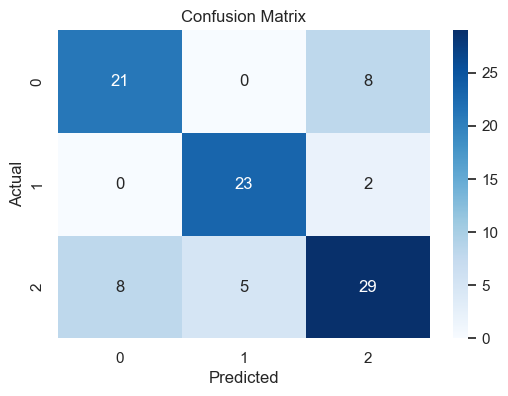

In [23]:
# Step 9: Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf.predict(X_test_scaled)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Optional: Cross-validation (uncomment to run)
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(rf, scaler.transform(X), y, cv=5, scoring='accuracy')
# print('5-fold CV accuracy: mean=%.4f std=%.4f' % (scores.mean(), scores.std()))

In [25]:
# Step 10: Save trained model and scaler for Streamlit UI
model_filename = 'model.pkl'
scaler_filename = 'scaler.pkl'
joblib.dump(rf, model_filename)
joblib.dump(scaler, scaler_filename)
print(f"Saved model to {model_filename} and scaler to {scaler_filename}")

Saved model to model.pkl and scaler to scaler.pkl


In [26]:
# Step 11: Example usage of saved model (single prediction)
# We'll take the first test row as an example
loaded_model = joblib.load('model.pkl')
loaded_scaler = joblib.load('scaler.pkl')

example = X_test.iloc[0:1]
print('Raw features:\n', example)
example_scaled = loaded_scaler.transform(example)
pred = loaded_model.predict(example_scaled)
print('\nPredicted class (encoded):', pred[0])
print('Class mapping (original):', list(df['Class'].unique()))

Raw features:
      gender  NationalITy  PlaceofBirth  StageID  GradeID  SectionID  Topic  \
336       0            7             3        2        0          0      4   

     Semester  Relation  raisedhands  VisITedResources  AnnouncementsView  \
336         0         1           70                90                 20   

     Discussion  ParentAnsweringSurvey  ParentschoolSatisfaction  \
336          21                      0                         1   

     StudentAbsenceDays  
336                   1  

Predicted class (encoded): 0
Class mapping (original): ['M', 'L', 'H']


In [27]:
# Run this in your notebook (after you have df, df_encoded from earlier cells)
from sklearn.preprocessing import LabelEncoder
import joblib

# Identify categorical columns (the ones we label-encoded in the notebook)
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Fit on original column (not encoded)
    le.fit(df[col].astype(str))
    encoders[col] = le

# Also save a LabelEncoder for the target 'Class' (useful to map numeric preds back to text)
le_target = LabelEncoder()
le_target.fit(df['Class'].astype(str))
encoders['Class'] = le_target

# Save encoders dict
joblib.dump(encoders, 'encoders.pkl')
print("Saved encoders for columns:", list(encoders.keys()))


Saved encoders for columns: ['gender', 'NationalITy', 'PlaceofBirth', 'StageID', 'GradeID', 'SectionID', 'Topic', 'Semester', 'Relation', 'ParentAnsweringSurvey', 'ParentschoolSatisfaction', 'StudentAbsenceDays', 'Class']
